In [1]:
import qiskit

In [2]:
pauli_list = [np.eye(2),np.array([[0.,1.],[1.,0.]]),np.array([[0,-1.j],[1.j,0.]]),np.array([[1.,0.],[0.,-1.]])]
s_to_pauli = {"I":pauli_list[0],"X":pauli_list[1], "Y":pauli_list[2],"Z":pauli_list[3]}

# Ancilla Based ShadowQPT

We'll now use the gates to create the n-qubit GHZ state (i.e. the GHZ process) as our process to perform quantum process tomography using classical shadows. Our target is the Choi matrix $\Lambda$

In [39]:
def channel(N,qc):
    '''create an N qubit GHZ state '''
    qc.h(0)
    if N>=2: qc.cx(0,1)
    if N>=3: qc.cx(0,2)
    if N>=4: qc.cx(1,3)
    if N>4: raise NotImplementedError(f"{N} not implemented!")

    
def bitGateMap(qc,g,qi):
    '''Map X/Y/Z string to qiskit ops'''
    if g=="X":
        qc.h(qi)
    elif g=="Y":
        qc.sdg(qi)
        qc.h(qi)
    elif g=="Z":
        pass
    else:
        raise NotImplementedError(f"Unknown gate {g}")
def Minv(N,X):
    '''inverse shadow channel'''
    return ((2**N+1.))*X - np.eye(2**N)

#from qiskit internals
def _funm_svd(matrix, func):
    """Apply real scalar function to singular values of a matrix.
    Args:
        matrix (array_like): (N, N) Matrix at which to evaluate the function.
        func (callable): Callable object that evaluates a scalar function f.
    Returns:
        ndarray: funm (N, N) Value of the matrix function specified by func
                 evaluated at `A`.
    """
    unitary1, singular_values, unitary2 = np.linalg.svd(matrix)
    diag_func_singular = np.diag(func(singular_values))
    return unitary1.dot(diag_func_singular).dot(unitary2)

def trace_dist(lam_exact,rho):
    mid = (lam_exact-rho).conj().T@(lam_exact-rho)
    N = 2**int(np.log2(lam_exact.shape[0])/2)
    dist = np.trace(_funm_svd(mid,np.sqrt))/2
    return dist/N

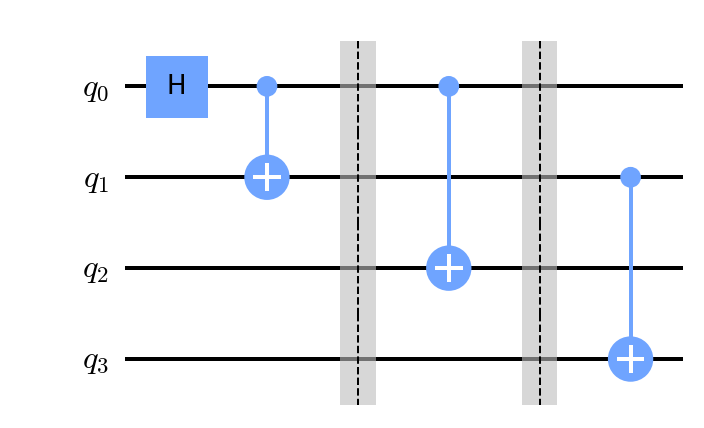

In [5]:
qc = qiskit.QuantumCircuit(4)
qc.h(0)
qc.cx(0,1)
qc.barrier()
qc.cx(0,2)
qc.barrier()
qc.cx(1,3)

qc.draw(output='mpl')

    

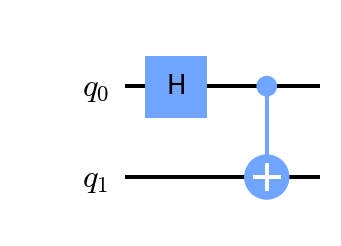

In [27]:
qc = qiskit.QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)

choi_actual = qiskit.quantum_info.Choi(qc)
qc.draw(output='mpl')

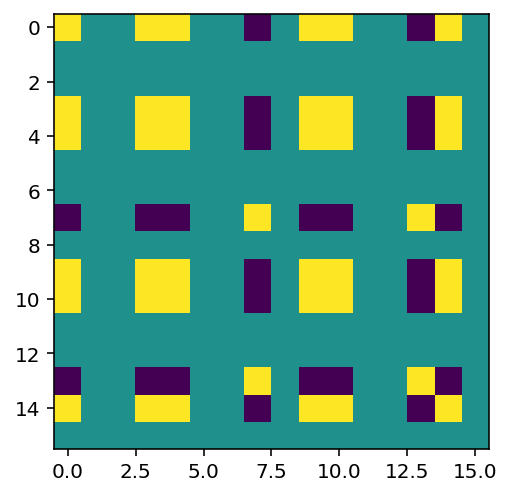

In [28]:
plt.imshow(choi_actual.data.real)

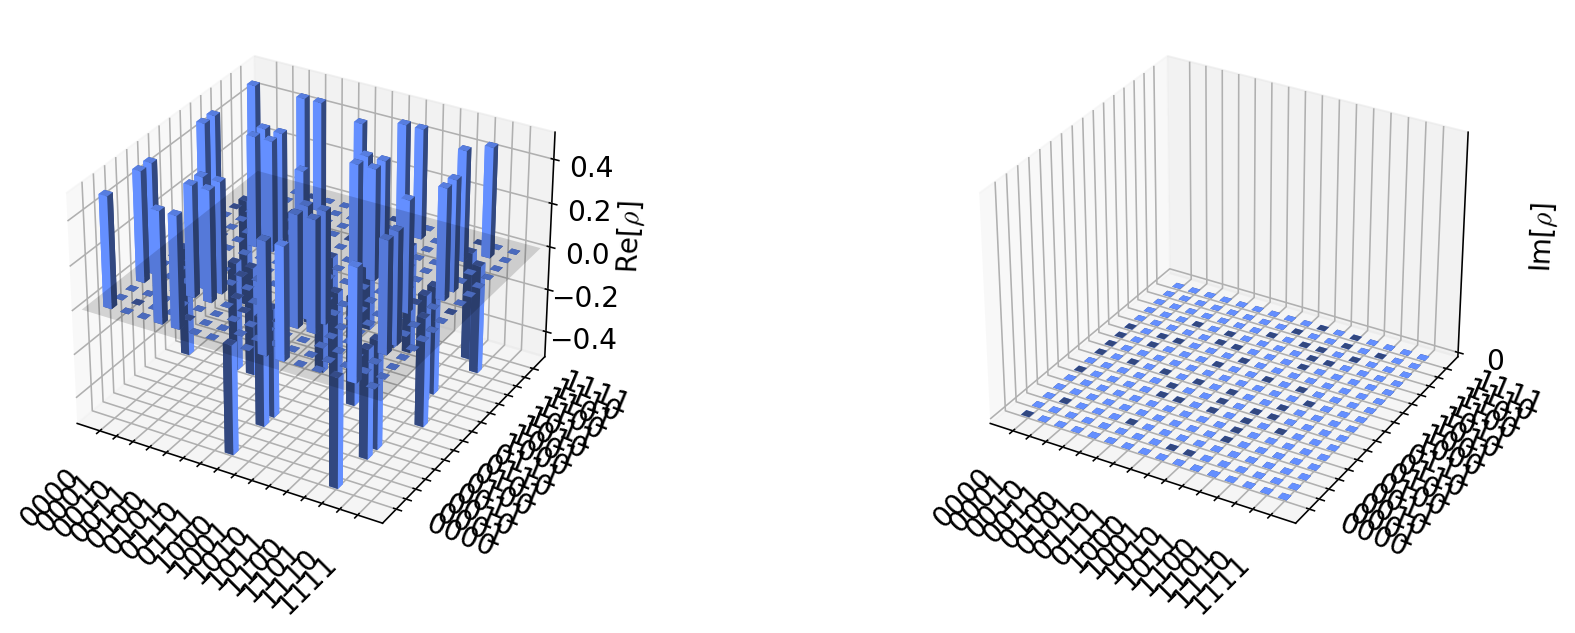

In [12]:
qiskit.visualization.state_visualization.plot_state_city(choi_actual.data)

Using ancillas, we can form a $n$-qubit channel 'problem' into a $2n$-qubit density matrix 'problem'

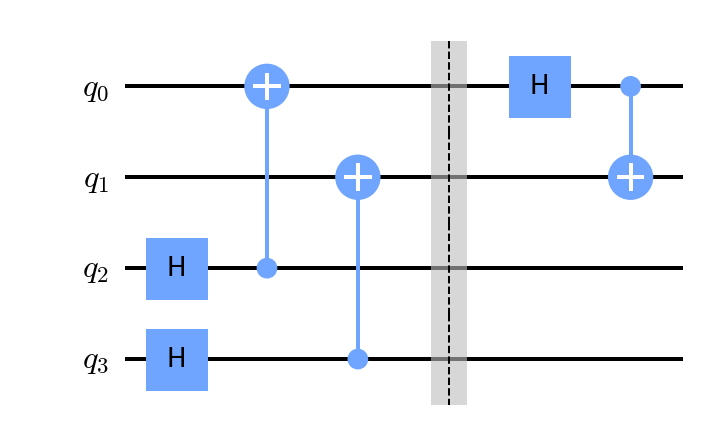

In [14]:
N = 2
qc = qiskit.QuantumCircuit(2*N)
for i in range(N):
    qc.h(i+N)
    qc.cx(i+N,i)
qc.barrier()
channel(N,qc)
qc.draw(output='mpl')

In [15]:
choi_state = qiskit.quantum_info.DensityMatrix(qc)
# this is the same up to normalization
# Tr[lambda] = 2^N
np.allclose(choi_state.data*2**N,choi_actual)

True

# Fixed $n$

## Clifford

In [62]:
nShadows = 1000
reps = 50
N = 2
rng = np.random.default_rng(1717)
cliffords = [qiskit.quantum_info.random_clifford(N*2,seed=rng) for _ in range(nShadows)]

N = 2
qc = qiskit.QuantumCircuit(2*N)
for i in range(N):
    qc.h(i+N)
    qc.cx(i+N,i)
channel(N,qc)

results = []
for cliff in cliffords:
    qc_c  = qc.compose(cliff.to_circuit())

    counts = qiskit.quantum_info.Statevector(qc_c).sample_counts(reps)
    results.append(counts)

In [63]:
rho_shadow = 0.+0j
for cliff,res in zip(cliffords,results):
    mat    = cliff.adjoint().to_matrix()
    for bit,count in res.items():
        Ub = mat[:,int(bit,2)] # this is Udag|b>
        rho_shadow += (Minv(N*2,np.outer(Ub,Ub.conj()))*count)

rho_shadow /=( nShadows*reps)
rho_shadow *= 2**N

In [64]:
assert np.allclose(rho_shadow.trace(),2**N)

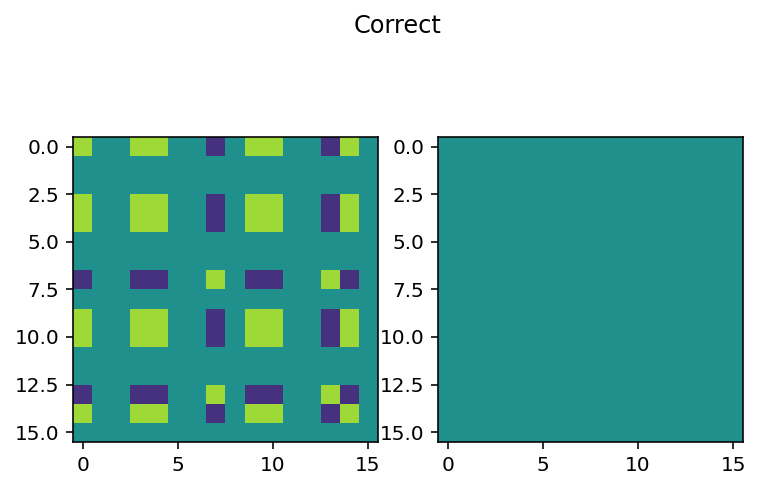

---


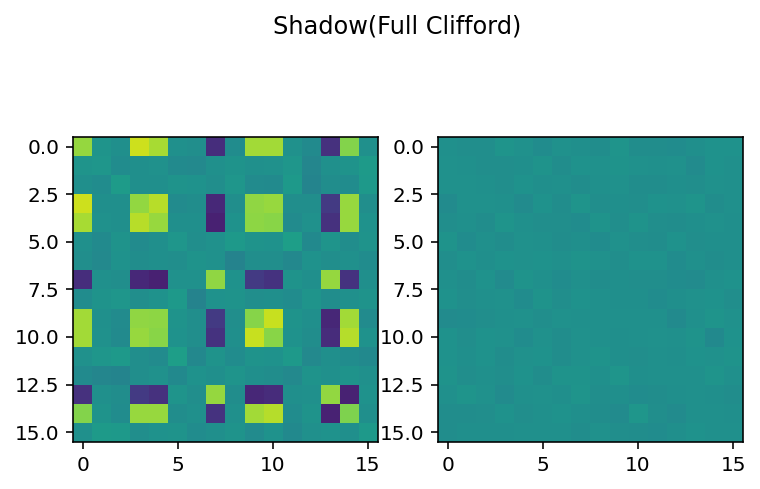

In [65]:


plt.subplot(121)
plt.suptitle("Correct")
plt.imshow(choi_actual.data.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(choi_actual.data.imag,vmax=0.7,vmin=-0.7)
plt.show()
print("---")

plt.subplot(121)
plt.suptitle("Shadow(Full Clifford)")
plt.imshow(rho_shadow.real,vmax=0.7,vmin=-0.7)
plt.subplot(122)
plt.imshow(rho_shadow.imag,vmax=0.7,vmin=-0.7)
plt.show()

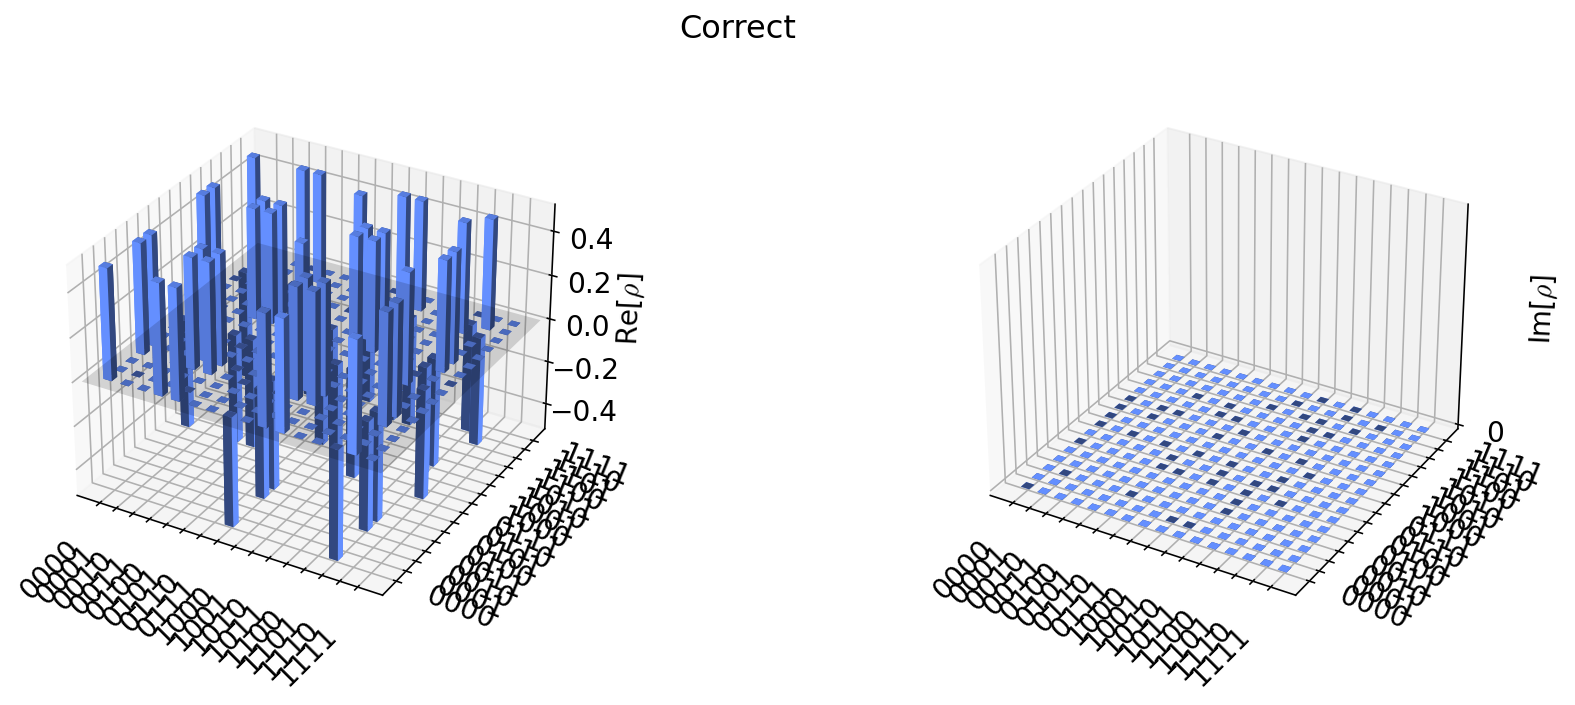

In [66]:
qiskit.visualization.state_visualization.plot_state_city(choi_actual.data,title="Correct")


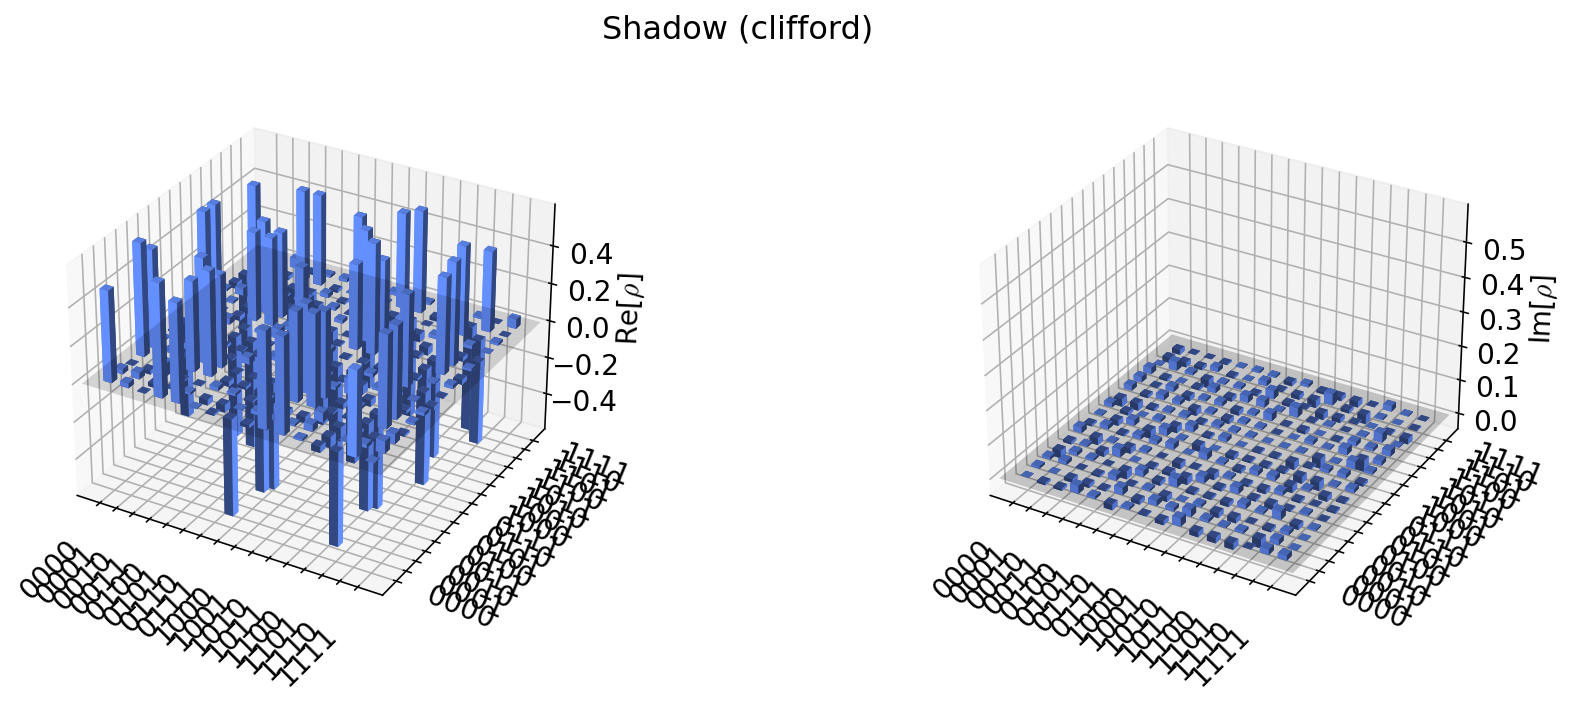

In [67]:
qiskit.visualization.state_visualization.plot_state_city(rho_shadow,title="Shadow (clifford)")


## Post Processing Steps

The shadow Choi matrix isn't very physical, so what can we do to fix that?
The easiest is purifying, which will project into the space of CPTP maps.   
For more advanced procedures, see [arxiv:1803.10062](https://arxiv.org/abs/1803.10062) (doi:10.1103/PhysRevA.98.062336)

In [68]:
_,vs = np.linalg.eigh(rho_shadow)
rho_shadow_pure = np.outer(vs[:,-1],vs[:,-1].conj().T)*2**N

In [69]:
print(f"original trace distance = {trace_dist(choi_actual.data,rho_shadow).real:0.4f}")
print(f"Purified  trace distance = {trace_dist(choi_actual.data,rho_shadow_pure).real:0.4f}")

original trace distance = 0.2213
Purified  trace distance = 0.0218
